In [1]:
# ✅ 필요한 라이브러리 불러오기
import os
import time
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio

from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam

# ✅ Google Drive 마운트 (Colab 사용 시)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 디렉토리 설정
base_dir = "/content/drive/MyDrive/aiffel/dcgan_newimage/cifar10"
generated_samples_dir = f"{base_dir}/generated_samples"
training_checkpoints_dir = f"{base_dir}/training_checkpoints"
training_history_dir = f"{base_dir}/training_history"

os.makedirs(generated_samples_dir, exist_ok=True)
os.makedirs(training_checkpoints_dir, exist_ok=True)
os.makedirs(training_history_dir, exist_ok=True)

print("✅ 폴더 생성 완료!")

Mounted at /content/drive
✅ 폴더 생성 완료!


In [2]:
# ✅ CIFAR-10 데이터셋 로드 및 전처리
(train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_x = (train_x.astype("float32") - 127.5) / 127.5  # [-1, 1]로 정규화
train_x = np.reshape(train_x, (-1, 32, 32, 3))

# ✅ 미니배치 구성
BATCH_SIZE = 256
BUFFER_SIZE = 60000

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

print("✅ 데이터셋 로드 및 전처리 완료!")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✅ 데이터셋 로드 및 전처리 완료!


In [3]:
# ✅ 생성자(Generator) 모델 구현
def build_generator():
    model = tf.keras.Sequential([
        Dense(8*8*256, use_bias=False, input_shape=(100,)),
        BatchNormalization(),
        ReLU(),
        Reshape((8, 8, 256)),

        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(3, (5, 5), strides=(1, 1), padding="same", activation="tanh"),
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,507 (10.43 MB)

 Trainable params: 2,700,355 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [4]:
# ✅ 판별자(Discriminator) 모델 구현
def build_discriminator():
    model = tf.keras.Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dense(1, activation="sigmoid"),
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,034,881 (3.95 MB)

 Trainable params: 1,034,113 (3.94 MB)

 Non-trainable params: 768 (3.00 KB)

In [5]:
# ✅ 손실 함수 및 최적화 함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# ✅ 체크포인트 설정
checkpoint_prefix = f"{training_checkpoints_dir}/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [6]:
# ✅ 학습 손실 기록을 위한 리스트
gen_losses = []
disc_losses = []

# ✅ 학습 과정
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([16, noise_dim])  # 16개의 고정된 seed

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_epoch = 0
        disc_loss_epoch = 0
        batch_count = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += gen_loss
            disc_loss_epoch += disc_loss
            batch_count += 1

        gen_losses.append(gen_loss_epoch / batch_count)
        disc_losses.append(disc_loss_epoch / batch_count)

        print(f"Epoch {epoch+1}/{epochs} 완료, 시간: {time.time()-start:.2f}초, "
              f"G_loss: {gen_losses[-1]:.4f}, D_loss: {disc_losses[-1]:.4f}")

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    plot_train_history()

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    plt.savefig(f"{generated_samples_dir}/image_at_epoch_{epoch}.png")
    plt.show()

def plot_train_history():
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss History")
    plt.savefig(f"{training_history_dir}/training_loss.png")
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/100 완료, 시간: 34.90초, G_loss: 5.8739, D_loss: 0.1166
Epoch 2/100 완료, 시간: 25.16초, G_loss: 6.7874, D_loss: 0.0442
Epoch 3/100 완료, 시간: 25.76초, G_loss: 4.6878, D_loss: 0.0468
Epoch 4/100 완료, 시간: 26.49초, G_loss: 5.5510, D_loss: 0.0253
Epoch 5/100 완료, 시간: 26.91초, G_loss: 5.6083, D_loss: 0.0235
Epoch 6/100 완료, 시간: 26.46초, G_loss: 4.6389, D_loss: 0.0655
Epoch 7/100 완료, 시간: 26.39초, G_loss: 5.3579, D_loss: 0.0435
Epoch 8/100 완료, 시간: 26.59초, G_loss: 5.3112, D_loss: 0.0367
Epoch 9/100 완료, 시간: 26.72초, G_loss: 5.8393, D_loss: 0.0599
Epoch 10/100 완료, 시간: 26.55초, G_loss: 5.2311, D_loss: 0.0422


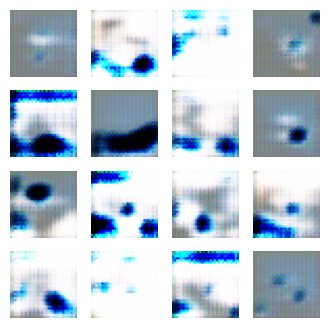

Epoch 11/100 완료, 시간: 26.60초, G_loss: 5.0005, D_loss: 0.0499
Epoch 12/100 완료, 시간: 26.68초, G_loss: 5.6525, D_loss: 0.0928
Epoch 13/100 완료, 시간: 26.50초, G_loss: 4.4721, D_loss: 0.0603
Epoch 14/100 완료, 시간: 26.58초, G_loss: 4.7154, D_loss: 0.0817
Epoch 15/100 완료, 시간: 26.65초, G_loss: 4.6159, D_loss: 0.1192
Epoch 16/100 완료, 시간: 26.55초, G_loss: 4.3503, D_loss: 0.1164
Epoch 17/100 완료, 시간: 26.54초, G_loss: 4.7144, D_loss: 0.0845
Epoch 18/100 완료, 시간: 26.57초, G_loss: 4.2252, D_loss: 0.1977
Epoch 19/100 완료, 시간: 26.62초, G_loss: 3.6147, D_loss: 0.1578
Epoch 20/100 완료, 시간: 26.65초, G_loss: 3.6395, D_loss: 0.1845


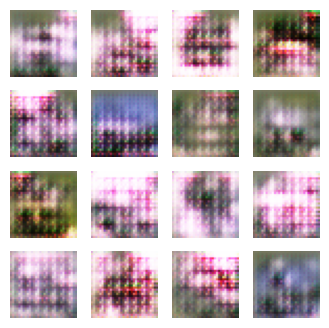

Epoch 21/100 완료, 시간: 26.60초, G_loss: 3.6859, D_loss: 0.1562
Epoch 22/100 완료, 시간: 26.55초, G_loss: 3.3907, D_loss: 0.2134
Epoch 23/100 완료, 시간: 26.58초, G_loss: 3.2962, D_loss: 0.2268
Epoch 24/100 완료, 시간: 26.56초, G_loss: 3.3507, D_loss: 0.2225
Epoch 25/100 완료, 시간: 26.62초, G_loss: 3.4920, D_loss: 0.2176
Epoch 26/100 완료, 시간: 26.75초, G_loss: 3.3903, D_loss: 0.2521
Epoch 27/100 완료, 시간: 26.68초, G_loss: 3.6533, D_loss: 0.2725
Epoch 28/100 완료, 시간: 26.65초, G_loss: 3.0129, D_loss: 0.3257
Epoch 29/100 완료, 시간: 26.56초, G_loss: 3.0379, D_loss: 0.3198
Epoch 30/100 완료, 시간: 26.60초, G_loss: 3.2984, D_loss: 0.2575


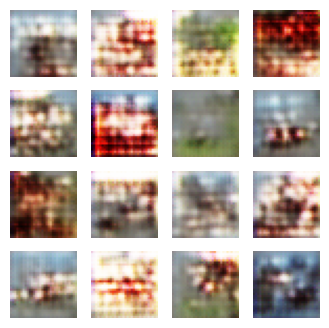

Epoch 31/100 완료, 시간: 26.66초, G_loss: 2.7799, D_loss: 0.3176
Epoch 32/100 완료, 시간: 26.62초, G_loss: 3.0235, D_loss: 0.2438
Epoch 33/100 완료, 시간: 26.56초, G_loss: 3.3668, D_loss: 0.2330
Epoch 34/100 완료, 시간: 26.58초, G_loss: 3.3888, D_loss: 0.2618
Epoch 35/100 완료, 시간: 26.58초, G_loss: 3.3039, D_loss: 0.2470
Epoch 36/100 완료, 시간: 26.57초, G_loss: 3.4064, D_loss: 0.2374
Epoch 37/100 완료, 시간: 26.59초, G_loss: 2.8604, D_loss: 0.3427
Epoch 38/100 완료, 시간: 26.62초, G_loss: 3.1880, D_loss: 0.2305
Epoch 39/100 완료, 시간: 26.64초, G_loss: 3.2884, D_loss: 0.2387
Epoch 40/100 완료, 시간: 26.64초, G_loss: 3.2076, D_loss: 0.3117


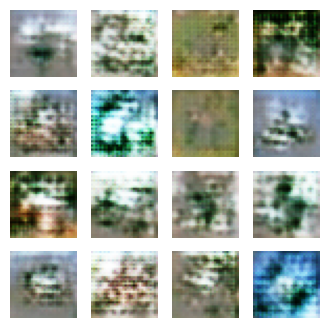

Epoch 41/100 완료, 시간: 26.60초, G_loss: 2.7467, D_loss: 0.3465
Epoch 42/100 완료, 시간: 26.62초, G_loss: 3.0370, D_loss: 0.3099
Epoch 43/100 완료, 시간: 26.62초, G_loss: 3.0233, D_loss: 0.3248
Epoch 44/100 완료, 시간: 26.63초, G_loss: 3.1723, D_loss: 0.2642
Epoch 45/100 완료, 시간: 26.62초, G_loss: 3.2373, D_loss: 0.2388
Epoch 46/100 완료, 시간: 26.61초, G_loss: 3.3735, D_loss: 0.2195
Epoch 47/100 완료, 시간: 26.65초, G_loss: 3.2746, D_loss: 0.2385
Epoch 48/100 완료, 시간: 26.65초, G_loss: 3.4676, D_loss: 0.2609
Epoch 49/100 완료, 시간: 26.63초, G_loss: 3.3504, D_loss: 0.2375
Epoch 50/100 완료, 시간: 26.66초, G_loss: 3.0968, D_loss: 0.3375


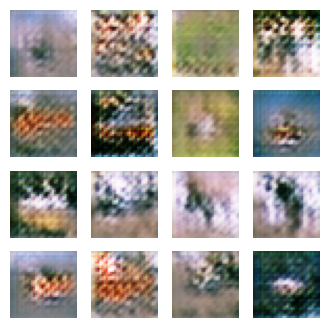

Epoch 51/100 완료, 시간: 26.66초, G_loss: 3.2495, D_loss: 0.2434
Epoch 52/100 완료, 시간: 26.66초, G_loss: 3.3120, D_loss: 0.2617
Epoch 53/100 완료, 시간: 26.65초, G_loss: 3.7589, D_loss: 0.1769
Epoch 54/100 완료, 시간: 26.64초, G_loss: 3.4652, D_loss: 0.2628
Epoch 55/100 완료, 시간: 26.63초, G_loss: 3.3086, D_loss: 0.2780
Epoch 56/100 완료, 시간: 26.63초, G_loss: 3.3780, D_loss: 0.2613
Epoch 57/100 완료, 시간: 26.64초, G_loss: 3.5054, D_loss: 0.2218
Epoch 58/100 완료, 시간: 26.66초, G_loss: 3.2374, D_loss: 0.2419
Epoch 59/100 완료, 시간: 26.66초, G_loss: 3.2076, D_loss: 0.2563
Epoch 60/100 완료, 시간: 26.65초, G_loss: 2.8405, D_loss: 0.3716


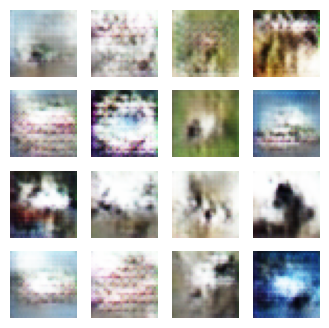

Epoch 61/100 완료, 시간: 26.65초, G_loss: 3.1047, D_loss: 0.3074
Epoch 62/100 완료, 시간: 26.65초, G_loss: 3.1974, D_loss: 0.3081
Epoch 63/100 완료, 시간: 26.65초, G_loss: 3.2216, D_loss: 0.2458
Epoch 64/100 완료, 시간: 26.63초, G_loss: 3.1997, D_loss: 0.3326
Epoch 65/100 완료, 시간: 26.64초, G_loss: 3.3089, D_loss: 0.3321
Epoch 66/100 완료, 시간: 26.64초, G_loss: 3.7102, D_loss: 0.2626
Epoch 67/100 완료, 시간: 26.66초, G_loss: 3.5132, D_loss: 0.2455
Epoch 68/100 완료, 시간: 26.64초, G_loss: 3.0645, D_loss: 0.3704
Epoch 69/100 완료, 시간: 26.65초, G_loss: 3.2622, D_loss: 0.2834
Epoch 70/100 완료, 시간: 26.66초, G_loss: 3.0583, D_loss: 0.2987


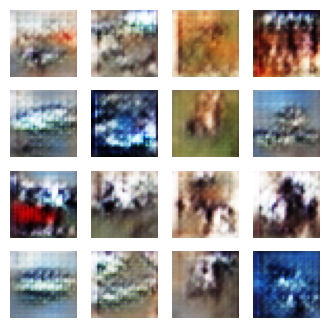

Epoch 71/100 완료, 시간: 26.63초, G_loss: 3.6310, D_loss: 0.2013
Epoch 72/100 완료, 시간: 40.94초, G_loss: 3.3776, D_loss: 0.3003
Epoch 73/100 완료, 시간: 26.81초, G_loss: 3.2166, D_loss: 0.2807
Epoch 74/100 완료, 시간: 27.07초, G_loss: 3.4161, D_loss: 0.2286
Epoch 75/100 완료, 시간: 26.42초, G_loss: 3.0336, D_loss: 0.3735
Epoch 76/100 완료, 시간: 26.54초, G_loss: 3.2815, D_loss: 0.3336
Epoch 77/100 완료, 시간: 26.75초, G_loss: 3.5474, D_loss: 0.2256
Epoch 78/100 완료, 시간: 26.64초, G_loss: 3.1001, D_loss: 0.3216
Epoch 79/100 완료, 시간: 26.57초, G_loss: 3.0040, D_loss: 0.3245
Epoch 80/100 완료, 시간: 26.61초, G_loss: 3.4775, D_loss: 0.2932


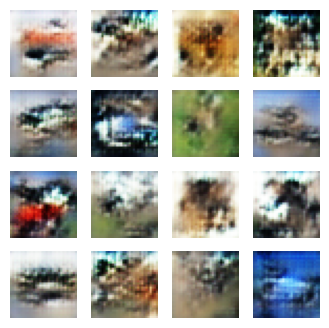

Epoch 81/100 완료, 시간: 26.62초, G_loss: 3.0030, D_loss: 0.3622
Epoch 82/100 완료, 시간: 26.60초, G_loss: 3.0865, D_loss: 0.3121
Epoch 83/100 완료, 시간: 26.60초, G_loss: 2.9629, D_loss: 0.3560
Epoch 84/100 완료, 시간: 26.63초, G_loss: 2.9123, D_loss: 0.4195
Epoch 85/100 완료, 시간: 26.60초, G_loss: 2.8391, D_loss: 0.4377
Epoch 86/100 완료, 시간: 26.61초, G_loss: 3.0049, D_loss: 0.4554
Epoch 87/100 완료, 시간: 26.61초, G_loss: 2.7435, D_loss: 0.4291
Epoch 88/100 완료, 시간: 26.62초, G_loss: 2.8194, D_loss: 0.3897
Epoch 89/100 완료, 시간: 26.63초, G_loss: 2.6821, D_loss: 0.4388
Epoch 90/100 완료, 시간: 26.60초, G_loss: 2.8644, D_loss: 0.3535


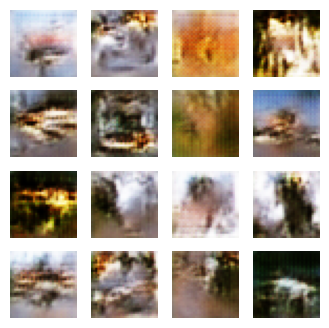

Epoch 91/100 완료, 시간: 26.61초, G_loss: 2.8810, D_loss: 0.3952
Epoch 92/100 완료, 시간: 26.63초, G_loss: 2.5265, D_loss: 0.5421
Epoch 93/100 완료, 시간: 26.64초, G_loss: 2.7316, D_loss: 0.3807
Epoch 94/100 완료, 시간: 26.64초, G_loss: 2.5533, D_loss: 0.5373
Epoch 95/100 완료, 시간: 26.66초, G_loss: 2.3740, D_loss: 0.5492
Epoch 96/100 완료, 시간: 26.63초, G_loss: 2.8370, D_loss: 0.3980
Epoch 97/100 완료, 시간: 26.64초, G_loss: 2.5992, D_loss: 0.5408
Epoch 98/100 완료, 시간: 26.66초, G_loss: 2.2967, D_loss: 0.5978
Epoch 99/100 완료, 시간: 26.65초, G_loss: 2.2098, D_loss: 0.5473
Epoch 100/100 완료, 시간: 26.62초, G_loss: 2.3298, D_loss: 0.5143


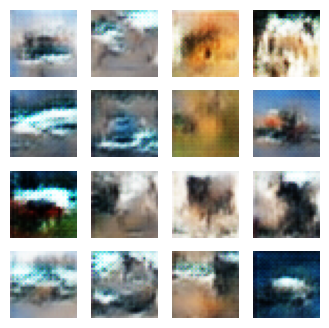

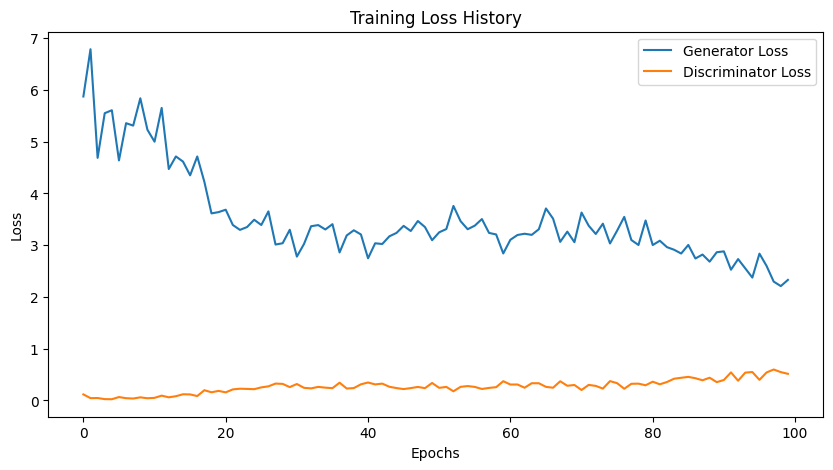

In [7]:
# ✅ 학습 실행
train(train_dataset, EPOCHS)


In [8]:
# ✅ GIF 생성 함수
def create_gif():
    anim_file = f"{generated_samples_dir}/cifar10_dcgan.gif"
    filenames = sorted(glob.glob(f"{generated_samples_dir}/image_at_epoch_*.png"))

    with imageio.get_writer(anim_file, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    print(f"✅ GIF 생성 완료! 저장 위치: {anim_file}")

create_gif()

<ipython-input-8-b4439c88aa60>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


✅ GIF 생성 완료! 저장 위치: /content/drive/MyDrive/aiffel/dcgan_newimage/cifar10/generated_samples/cifar10_dcgan.gif
